In [10]:
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
import importlib
from matplotlib import pyplot as plt
importlib.reload(random_rm_trace_generator)

<module 'helper_scripts.random_rm_trace_generator' from '/cr/work/kastner/private/umap/rm_classifier/tutorials/notebooks/helper_scripts/random_rm_trace_generator.py'>

In [13]:
random_rm_trace_generator.generate_fourier_time_traces(4)

(array([0.        , 0.00097656, 0.00195312, 0.00292969, 0.00390625,
        0.00488281, 0.00585938, 0.00683594, 0.0078125 , 0.00878906,
        0.00976562, 0.01074219, 0.01171875, 0.01269531, 0.01367188,
        0.01464844, 0.015625  , 0.01660156, 0.01757812, 0.01855469,
        0.01953125, 0.02050781, 0.02148438, 0.02246094, 0.0234375 ,
        0.02441406, 0.02539062, 0.02636719, 0.02734375, 0.02832031,
        0.02929688, 0.03027344, 0.03125   , 0.03222656, 0.03320312,
        0.03417969, 0.03515625, 0.03613281, 0.03710938, 0.03808594,
        0.0390625 , 0.04003906, 0.04101562, 0.04199219, 0.04296875,
        0.04394531, 0.04492188, 0.04589844, 0.046875  , 0.04785156,
        0.04882812, 0.04980469, 0.05078125, 0.05175781, 0.05273438,
        0.05371094, 0.0546875 , 0.05566406, 0.05664062, 0.05761719,
        0.05859375, 0.05957031, 0.06054688, 0.06152344, 0.0625    ,
        0.06347656, 0.06445312, 0.06542969, 0.06640625, 0.06738281,
        0.06835938, 0.06933594, 0.0703125 , 0.07

In [49]:
a=random_rm_trace_generator.generate_fourier_time_traces(4, noise_level=0.2)[1]

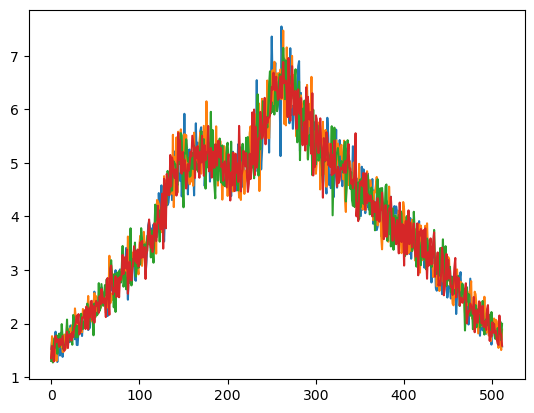

In [50]:
for i in range(4):
    plt.plot(a[i], label=f'Trace {i+1}')